# **Dynamic Momentum Zones (DMZ)**
## 创新交易策略

**了解如何应用动态动量区 (DMZ)** 策略来最大限度地提高您在金融市场的机会。

> **免责声明：*本文内容仅仅是技术探讨和学习，并不构成任何投资建议。

## **第 1 步：数据加载和准备**

我们将使用 `yfinance` API 获取资产（欧元/美元）的历史数据。此步骤准备用于数据分析。

[*********************100%***********************]  1 of 1 completed


Index(['Adj Close_EURUSD=X', 'Close_EURUSD=X', 'High_EURUSD=X', 'Low_EURUSD=X',
       'Open_EURUSD=X', 'Volume_EURUSD=X'],
      dtype='object')


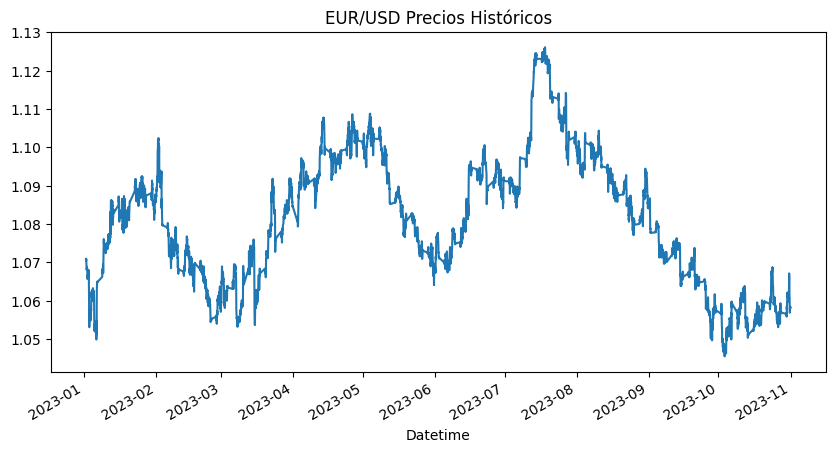

In [74]:

# 导入必要的库
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 下载 EUR/USD 历史数据
ticker = "EURUSD=X"  # 资产：欧元兑美元
data = yf.download(ticker, start="2023-01-01", end="2023-11-01", interval="1h")
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns]

# 检查更改后的列
print(data.columns)

# 数据整理
data.dropna(inplace=True)

# 初始数据显示
data['Close_'+ticker].plot(title="EUR/USD 历史价格", figsize=(10, 5))
plt.show()


## **第二步：关键指标计算**

我们将计算布林线、RSI 和 ATR 来检测关键区域。

In [75]:
# 重置索引以确保它是一个简单索引
data = data.reset_index()

# 如果不需要，可以选择删除“股票代码”列
if 'Ticker' in data.columns:
    data = data.drop(columns=['Ticker'])

# 再次将日期时间列设置为索引
data = data.set_index('Datetime')

In [76]:
print(data['Close_'+ticker].dtypes) 

float64


In [77]:
data['MA20'] = data['Close_'+ticker].rolling(window=20).mean()

# 计算20个周期的标准差
rolling_std = data['Close_'+ticker].rolling(window=20).std()

In [78]:
rolling_std = rolling_std.squeeze()  # 必要时将其转换为系列
data['Close_'+ticker] = data['Close_'+ticker].squeeze()

In [79]:
print(type(data['Close_'+ticker]))
print(type(rolling_std))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


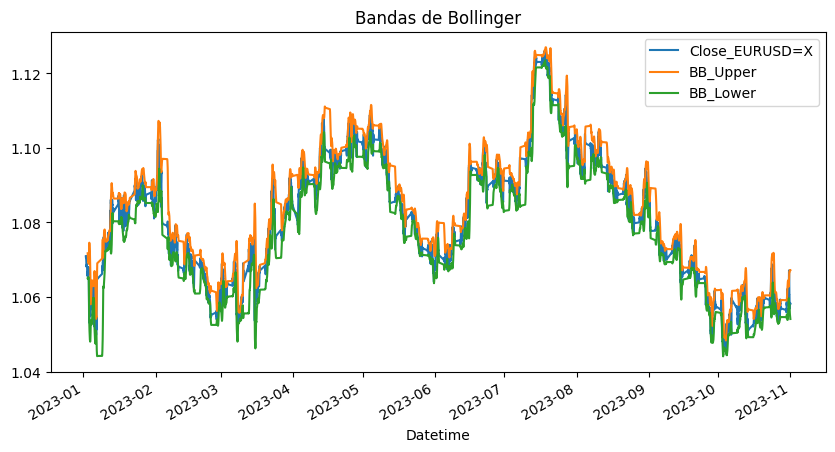

In [80]:


# 布林线计算
data['BB_Upper'] = data['MA20'] + (2 * rolling_std)
data['BB_Lower'] = data['MA20'] - (2 * rolling_std)

# 相对强弱指数计算
# 计算差价
delta = data['Close_'+ticker].diff()

# 计算利润和损失
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

# Convertir a Series
gain = pd.Series(gain, index=data.index)
loss = pd.Series(loss, index=data.index)

# 计算移动平均线
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()

# 避免被零除
rs = avg_gain / avg_loss.replace(0, np.nan)

# 计算RSI
data['RSI'] = 100 - (100 / (1 + rs))


#计算 ATR
high_low = data['High_'+ticker] - data['Low_'+ticker]
high_close = abs(data['High_'+ticker] - data['Close_'+ticker].shift())
low_close = abs(data['Low_'+ticker] - data['Close_'+ticker].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
data['ATR'] = true_range.rolling(window=14).mean()

# 布林线可视化
data[['Close_'+ticker, 'BB_Upper', 'BB_Lower']].plot(title="布林线", figsize=(10, 5))
plt.show()


## **第 3 步：交易信号的定义**

我们根据策略定义买入和卖出信号的条件。

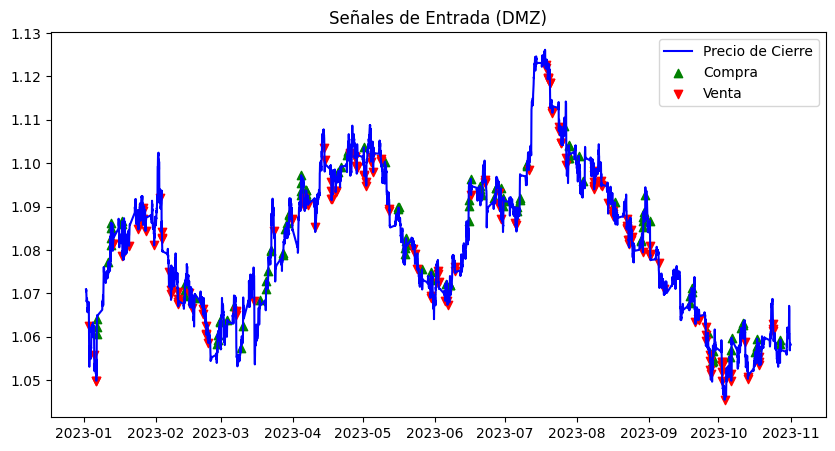

In [81]:

# 买入信号（多头）
data['Long_Entry'] = (
    (data['Close_'+ticker] > data['BB_Upper']) & 
    (data['RSI'] > 50) & (data['RSI'] < 70) & 
    (data['ATR'] > data['ATR'].rolling(window=10).mean())
)

# 卖出信号（短）
data['Short_Entry'] = (
    (data['Close_'+ticker] < data['BB_Lower']) & 
    (data['RSI'] > 25) & (data['RSI'] < 40) & 
    (data['ATR'] > data['ATR'].rolling(window=10).mean())
)

# 信号显示
plt.figure(figsize=(10, 5))
plt.plot(data['Close_'+ticker], label="收盘价", color="blue")
plt.scatter(data.index[data['Long_Entry']], data['Close_'+ticker][data['Long_Entry']], label="买", marker="^", color="green")
plt.scatter(data.index[data['Short_Entry']], data['Close_'+ticker][data['Short_Entry']], label="卖", marker="v", color="red")
plt.title("进入信号(DMZ)")
plt.legend()
plt.show()


## **步骤 4：简单回测**

我们进行性能分析，将 DMZ 策略与市场进行比较。

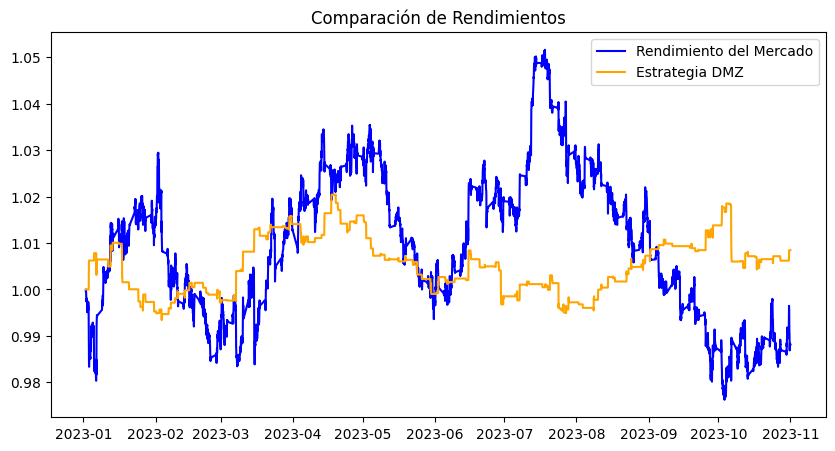

In [85]:

#初始化位置
data['Position'] = 0
data.loc[data['Long_Entry'], 'Position'] = 1  # Posiciones largas
data.loc[data['Short_Entry'], 'Position'] = -1  # Posiciones cortas
data['Position'] = data['Position'].shift()

# 计算回报
data['Returns'] = data['Close_'+ticker].pct_change()
data['Strategy'] = data['Position'] * data['Returns']

# 累计业绩
data['Cumulative_Market'] = (1 + data['Returns']).cumprod()
data['Cumulative_Strategy'] = (1 + data['Strategy']).cumprod()

# 结果图
plt.figure(figsize=(10, 5))
plt.plot(data['Cumulative_Market'], label="Rendimiento del Mercado", color="blue")
plt.plot(data['Cumulative_Strategy'], label="Estrategia DMZ", color="orange")
plt.title("Comparación de Rendimientos")
plt.legend()
plt.show()


In [86]:
data['Returns']

Datetime
2023-01-02 00:00:00+00:00         NaN
2023-01-02 01:00:00+00:00   -0.000214
2023-01-02 02:00:00+00:00   -0.000214
2023-01-02 03:00:00+00:00    0.000428
2023-01-02 04:00:00+00:00   -0.000749
                               ...   
2023-10-31 19:00:00+00:00    0.000000
2023-10-31 20:00:00+00:00   -0.000423
2023-10-31 21:00:00+00:00    0.000000
2023-10-31 22:00:00+00:00    0.000212
2023-10-31 23:00:00+00:00    0.000000
Name: Returns, Length: 5163, dtype: float64

### 优化与仿真
Para mejorar la estrategia, podemos optimizar parámetros (como el RSI o la longitud del ATR) usando scipy o una biblioteca como optuna.

Por ejemplo, optimizar el rango del RSI:

In [87]:
from scipy.optimize import minimize

# 广义优化函数
def optimize_strategy(params):
    # 解压参数
    rsi_lower, rsi_upper, atr_multiplier, bb_upper_margin, bb_lower_margin = params
    
    # 使用当前参数生成信号
    data['Long_Entry'] = (
        (data['Close_'+ticker] > data['BB_Upper'] * bb_upper_margin) & 
        (data['RSI'] > rsi_lower) & (data['RSI'] < rsi_upper) & 
        (data['ATR'] > data['ATR'].rolling(window=10).mean() * atr_multiplier)
    )
    data['Short_Entry'] = (
        (data['Close_'+ticker] < data['BB_Lower'] * bb_lower_margin) & 
        (data['RSI'] > rsi_lower - 30) & (data['RSI'] < rsi_upper - 30) & 
        (data['ATR'] > data['ATR'].rolling(window=10).mean() * atr_multiplier)
    )
    
    # 初始化位置
    data['Position'] = 0
    data.loc[data['Long_Entry'], 'Position'] = 1
    data.loc[data['Short_Entry'], 'Position'] = -1
    data['Position'] = data['Position'].shift()
    
    # 计算策略
    data['Strategy'] = data['Position'] * data['Returns']
    
    # 返回负指标（最大化累积回报）
    return -data['Strategy'].sum()

# 优化参数
initial_params = [50, 70, 0.9, 0.98, 1.02]  # Valores iniciales: RSI, ATR y Bandas de Bollinger
bounds = [
    (30, 60),  # rsi_lower
    (65, 80),  # rsi_upper
    (0.5, 1.5),  # atr_multiplier
    (0.9, 1.1),  # bb_upper_margin
    (0.9, 1.1)   # bb_lower_margin
]

# 执行优化
result = minimize(optimize_strategy, x0=initial_params, bounds=bounds)

# 显示结果
print("最佳参数:")
print(f"RSI Lower: {result.x[0]:.2f}, RSI Upper: {result.x[1]:.2f}")
print(f"ATR Multiplier: {result.x[2]:.2f}")
print(f"BB Upper Margin: {result.x[3]:.2f}, BB Lower Margin: {result.x[4]:.2f}")


Parámetros Óptimos:
RSI Lower: 50.00, RSI Upper: 70.00
ATR Multiplier: 0.90
BB Upper Margin: 0.98, BB Lower Margin: 1.02


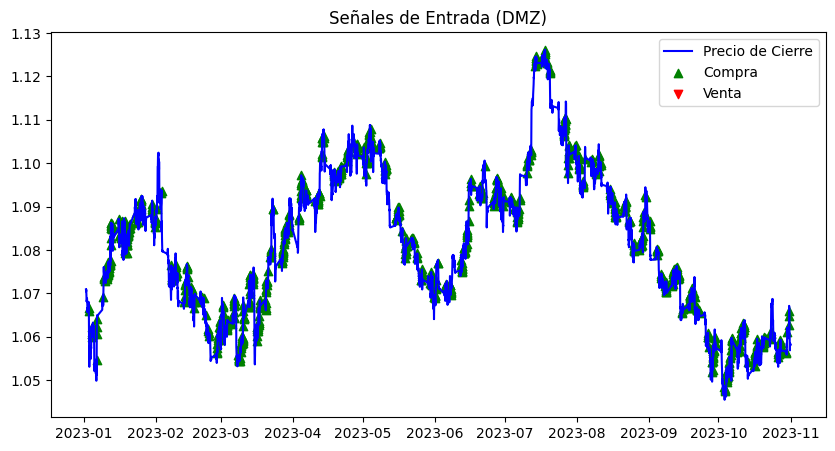

In [88]:

# 买入信号（多头）
data['Long_Entry'] = (
    (data['Close_'+ticker] > data['BB_Upper']*0.98) & 
    (data['RSI'] > 50) & (data['RSI'] < 70) & 
    (data['ATR'] > data['ATR'].rolling(window=10).mean()*0.9)
)

# 卖出信号（短）
data['Short_Entry'] = (
    (data['Close_'+ticker] < data['BB_Lower']*1.02) & 
    (data['RSI'] > 20) & (data['RSI'] < 20) & 
    (data['ATR'] > data['ATR'].rolling(window=10).mean()*0.9)
)

# 信号显示
plt.figure(figsize=(10, 5))
plt.plot(data['Close_'+ticker], label="Precio de Cierre", color="blue")
plt.scatter(data.index[data['Long_Entry']], data['Close_'+ticker][data['Long_Entry']], label="Compra", marker="^", color="green")
plt.scatter(data.index[data['Short_Entry']], data['Close_'+ticker][data['Short_Entry']], label="Venta", marker="v", color="red")
plt.title("Señales de Entrada (DMZ)")
plt.legend()
plt.show()

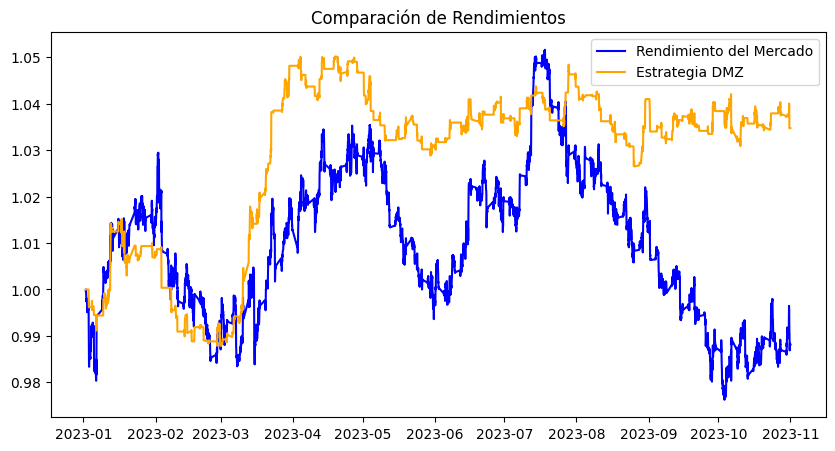

In [89]:
# 初始化位置
data['Position'] = 0
data.loc[data['Long_Entry'], 'Position'] = 1  # Posiciones largas
data.loc[data['Short_Entry'], 'Position'] = -1  # Posiciones cortas
data['Position'] = data['Position'].shift()

# 计算回报
data['Returns'] = data['Close_'+ticker].pct_change()
data['Strategy'] = data['Position'] * data['Returns']

# 累计业绩
data['Cumulative_Market'] = (1 + data['Returns']).cumprod()
data['Cumulative_Strategy'] = (1 + data['Strategy']).cumprod()

# 结果图
plt.figure(figsize=(10, 5))
plt.plot(data['Cumulative_Market'], label="Rendimiento del Mercado", color="blue")
plt.plot(data['Cumulative_Strategy'], label="Estrategia DMZ", color="orange")
plt.title("Comparación de Rendimientos")
plt.legend()
plt.show()

## **Conclusión**

DMZ 策略展示了自适应技术分析如何识别市场中的关键机会区域。但是，请始终记住实时交易前风险管理和回溯测试的重要性。

> **Nota:** 本内容仅仅是技术探讨和学习，并不构成任何投资建议。